In [1]:
import scanpy as sc

import pyro
import pyro.distributions as dist

import torch

adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/OCT2025/spatial-transformer/models/17OCT2025/adata-cell-leiden.h5ad")
adata = adata[adata.layers["transcript"].sum(axis=1) > 150]
adata = adata[adata.obs["folder"].eq("99-15")]

/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

log_exposure = np.log(adata.layers["transcript"].sum(axis=1) / adata.layers["transcript"].sum(axis=1).mean())

device="cuda"
data = {
    "counts": torch.tensor(adata.layers["transcript"]).float().to(device),
    "log_exposure": torch.tensor(log_exposure).float().to(device)
}

In [3]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn.functional as F

def stick_breaking(v, eps=1e-3):
    # v: [K]
    one_minus_v = torch.clamp(1 - v, min=eps)
    remaining_stick = torch.cat([
        torch.tensor([1.], device=v.device), 
        one_minus_v.cumprod(dim=0)[:-1]
    ])
    return v * remaining_stick  # shape: [K]

In [20]:
K = 50
alpha = 10
def model(data, K = K, alpha = alpha):
    device = data["counts"].device
    N, F = data["counts"].shape

    # crp_alpha = pyro.sample(
    #     "crp_alpha",
    #     dist.LogNormal(0.5, .3)
    # )
    # crp_alpha_stable = torch.clamp(crp_alpha, min=1e-3, max=1e3)
    crp_alpha = torch.tensor(alpha, device=device)

    v_k = pyro.sample(
        "v_k",
        dist.Beta(
            torch.ones(K, device=device), 
            crp_alpha.expand(K)
        ).to_event(1)
    )
    pi_k = stick_breaking(v_k)

    pi_logits_loc = torch.zeros(K, F, device=device)
    pi_logits_scale = torch.ones(K, F, device=device) * 0.3
    pi_logits = pyro.sample(
        "pi_logits",
        dist.Normal(
            pi_logits_loc,
            pi_logits_scale
        ).to_event(2)
    )

    nb_logits_loc = torch.zeros(K, F, device=device)
    nb_logits_scale = torch.ones(K, F, device=device) * 0.3
    nb_logits = pyro.sample(
        "nb_logits",
        dist.Normal(
            nb_logits_loc,
            nb_logits_scale
        ).to_event(2)
    )

    total_count_loc = torch.zeros(K, F, device=device)
    total_count_scale = torch.ones(K, F, device=device) * 0.3
    total_count = pyro.sample(
        "total_count",
        dist.LogNormal(
            total_count_loc,
            total_count_scale
        ).to_event(2)
    )

    log_exposure_expanded = data["log_exposure"].unsqueeze(1).unsqueeze(2)

    pi_logits_expanded = pi_logits.unsqueeze(0).expand(N, K, F)
    nb_logits_expanded = nb_logits.unsqueeze(0).expand(N, K, F)
    total_count_expanded = total_count.unsqueeze(0).expand(N, K, F)

    nb_logits = nb_logits_expanded + log_exposure_expanded
    zero_inflation_logits = pi_logits_expanded + log_exposure_expanded

    pyro.sample(
        "obs",
        dist.MixtureSameFamily(
            mixture_distribution=dist.Categorical(pi_k).expand([N]),
            component_distribution=dist.Independent(
                dist.ZeroInflatedDistribution(
                    base_dist=dist.NegativeBinomial(
                        logits=nb_logits,
                        total_count=total_count_expanded.exp()
                    ),
                    gate_logits=zero_inflation_logits
                ),
                reinterpreted_batch_ndims=1
            )
        ).to_event(1),
        obs=data["counts"]
    )

def guide(data, K = K, alpha=alpha):
    device = data["counts"].device
    N, F = data["counts"].shape

    # crp_alpha_loc = pyro.param(
    #     "crp_alpha_loc",
    #     torch.ones(1, device=device) * .5,
    #     constraint=dist.constraints.real
    # )
    # crp_alpha_scale = pyro.param(
    #     "crp_alpha_scale",
    #     torch.ones(1, device=device) * .3,
    #     constraint=dist.constraints.positive
    # )
    # crp_alpha = pyro.sample(
    #     "crp_alpha",
    #     dist.LogNormal(
    #         crp_alpha_loc,
    #         crp_alpha_scale
    #     )
    # )
    # crp_alpha_stable = torch.clamp(
    #     crp_alpha,
    #     min=1e-3,
    #     max=1e3
    # )
    crp_alpha = torch.tensor(alpha, device=device)

    v_k = pyro.sample(
        "v_k",
        dist.Beta(
            torch.ones(K, device=device), 
            crp_alpha.expand(K)
        ).to_event(1)
    )
    pi_k = stick_breaking(v_k)

    pi_logits_loc = pyro.param(
        "pi_logits_loc",
        torch.zeros(K, F, device=device),
        constraint=dist.constraints.real
    )
    pi_logits_scale = pyro.param(
        "pi_logits_scale",
        torch.ones(K, F, device=device) * 0.3,
        constraint=dist.constraints.positive
    )
    pi_logits = pyro.sample(
        "pi_logits",
        dist.Normal(
            pi_logits_loc,
            pi_logits_scale
        ).to_event(2)
    )

    nb_logits_loc = pyro.param(
        "nb_logits_loc",
        torch.zeros(K, F, device=device) ,
        constraint=dist.constraints.real
    )
    nb_logits_scale = pyro.param(
        "nb_logits_scale",
        torch.ones(K, F, device=device) * 0.3,
        constraint=dist.constraints.positive
    )
    nb_logits = pyro.sample(
        "nb_logits",
        dist.Normal(
            nb_logits_loc,
            nb_logits_scale
        ).to_event(2)
    )

    total_count_loc = pyro.param(
        "total_count_loc",
        torch.zeros(K, F, device=device),
        constraint=dist.constraints.real
    )
    total_count_scale = pyro.param(
        "total_count_scale",
        torch.ones(K, F, device=device) * 0.3,
        constraint=dist.constraints.positive
    )
    total_count = pyro.sample(
        "total_count",
        dist.LogNormal(
            total_count_loc,
            total_count_scale
        ).to_event(2)
    )

In [21]:
import pyro
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
import torch
from tqdm import trange
import matplotlib.pyplot as plt

# pyro.clear_param_store()
# --- SVI setup ---

# optimizer = optim.Adam({"lr": base_lr})
optimizer = pyro.optim.ClippedAdam({"lr": 1e-2, "clip_norm": 10.0})

svi = SVI(model, guide, optimizer, loss=TraceMeanField_ELBO())

def effective_num_clusters(pi_k, threshold=1e-3):
    return torch.sum(pi_k > threshold).item()

# --- Training loop ---
num_steps = 5000
losses = []

progress_bar = trange(num_steps, desc="Training", leave=True)
for step in progress_bar:
    loss = svi.step(data)
    losses.append(loss)

    progress_bar.set_postfix({
        "ELBO": f"{loss:.2f}",
        "K": f"{(dict(pyro.get_param_store())['pi_logits_loc'].var(1).detach().cpu().numpy() > 1).sum()}"
    })

Training:   0%|          | 0/5000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.58 GiB. GPU 0 has a total capacity of 23.49 GiB of which 909.69 MiB is free. Including non-PyTorch memory, this process has 21.86 GiB memory in use. Of the allocated memory 19.85 GiB is allocated by PyTorch, and 1.58 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<Axes: >

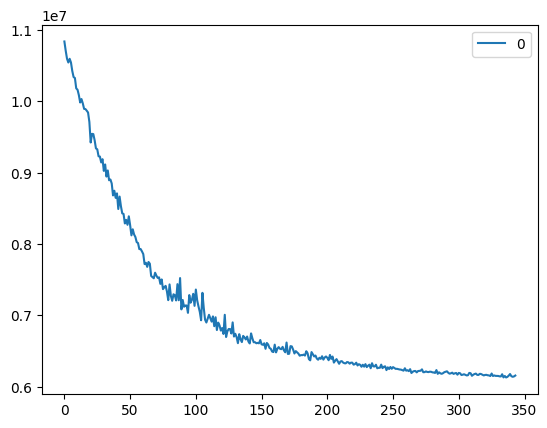

In [6]:
import pandas as pd
pd.DataFrame(losses).plot()

/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


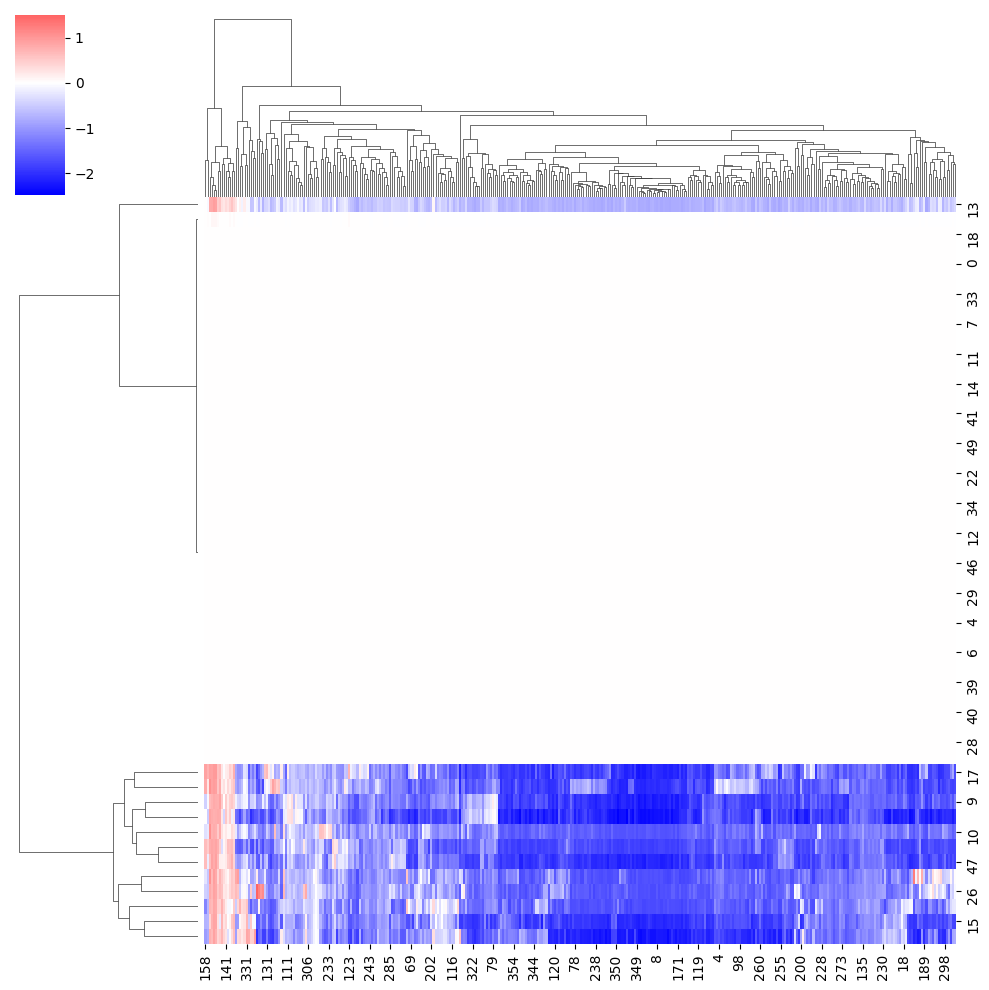

In [7]:
import seaborn as sns
sns.clustermap(
    dict(pyro.get_param_store())["nb_logits_loc"].detach().cpu().numpy(),
    cmap="bwr",
    center=0
)

/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jhaberbe/Projects/Personal/OCT2025/vi-chinese-restaurant-process/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


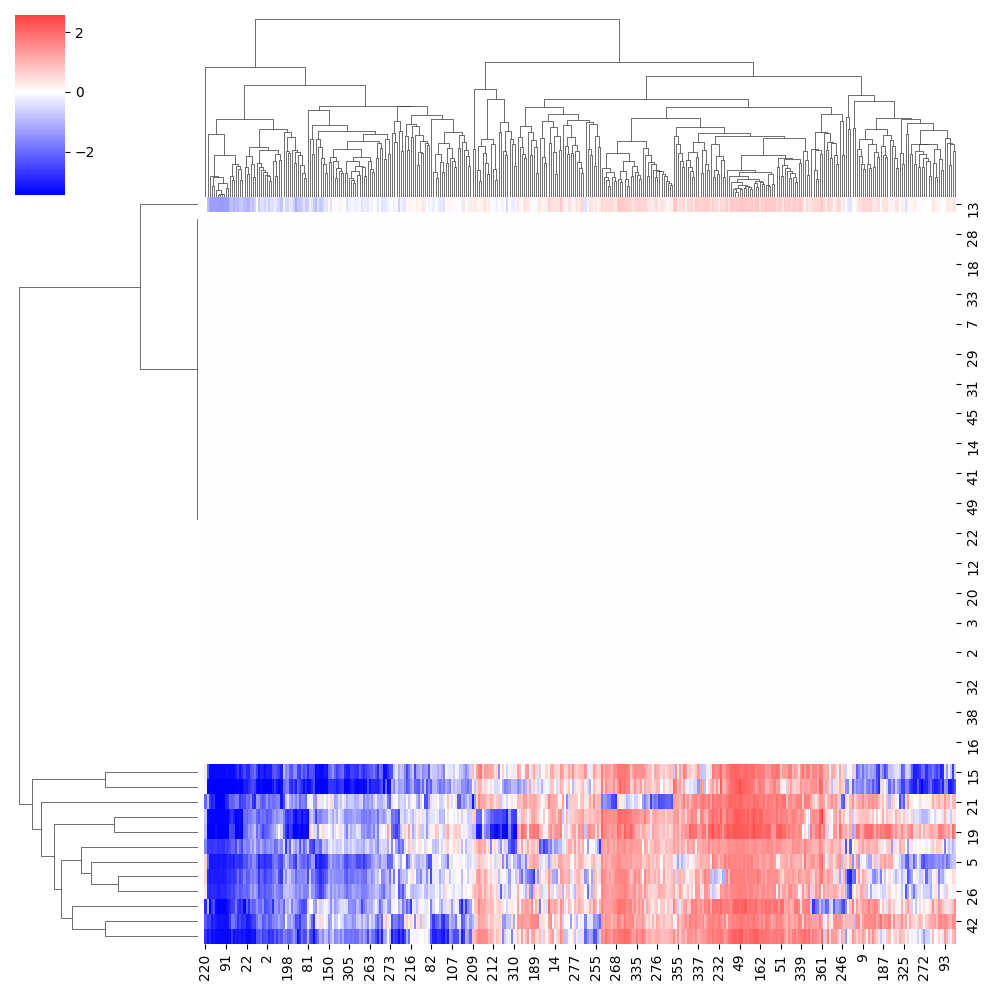

In [8]:
import seaborn as sns
sns.clustermap(
    dict(pyro.get_param_store())["pi_logits_loc"].detach().cpu().numpy(),
    cmap="bwr",
    center=0
)

In [9]:

import torch
import pyro
import pyro.distributions as dist

def remap_to_lowest(ids):
    """
    Remap a list of integers to the lowest consecutive integers starting from 1.

    Args:
        ids (list[int]): List of integers (may be unordered and non-consecutive)

    Returns:
        list[int]: List of remapped integers starting from 1
    """
    unique_sorted = sorted(set(ids))  # unique values in sorted order
    mapping = {old: new for new, old in enumerate(unique_sorted, start=1)}
    return [mapping[x] for x in ids]

def predict_clusters_fixed_alpha(data, param_store=None):
    """
    Predict cluster assignments for the fixed-alpha stick-breaking ZINB mixture model.

    Args:
        data: dict with key "counts" (and optionally "log_exposure"), shape [N, F].
        param_store: optional Pyro param store (defaults to pyro.get_param_store()).

    Returns:
        cluster_assignments: LongTensor of shape [N], most likely cluster index per data point.
    """
    device = data["counts"].device
    counts = data["counts"]  # [N, F]
    log_exposure = data.get("log_exposure", torch.zeros_like(counts))  # optional exposure correction
    N, F = counts.shape

    if param_store is None:
        param_store = dict(pyro.get_param_store())

    # --- Retrieve variational parameters ---
    pi_logits_loc = param_store["pi_logits_loc"].detach()        # [K, F]
    nb_logits_loc = param_store["nb_logits_loc"].detach()        # [K, F]
    total_count_loc = param_store["total_count_loc"].detach()    # [K, F]

    K = nb_logits_loc.shape[0]

    # --- Stick-breaking weights ---
    # Fixed crp_alpha = 1 → v_k ~ Beta(1, 1) → uniform prior over components
    # So we just use uniform weights here for prediction
    pi_k = torch.ones(K, device=device) / K  # [K]

    # --- Compute per-cluster distributions ---
    total_count = total_count_loc.exp()                     # ensure positive [K, F]
    nb_logits = nb_logits_loc + log_exposure.mean(0, keepdim=True)  # add exposure correction
    gate_logits = pi_logits_loc + log_exposure.mean(0, keepdim=True)

    # --- Compute log-likelihood per cluster for each data point ---
    log_probs = []
    for k in range(K):
        nb_dist = dist.NegativeBinomial(
            total_count=total_count[k],
            logits=nb_logits[k]
        )

        zinb_dist = dist.ZeroInflatedDistribution(
            base_dist=nb_dist,
            gate_logits=gate_logits[k]
        )

        # [N, F] → sum across features for [N]
        log_prob_nf = zinb_dist.log_prob(counts)
        log_prob_n = log_prob_nf.sum(dim=-1)
        log_probs.append(log_prob_n)

    log_probs = torch.stack(log_probs, dim=1)  # [N, K]

    # --- Add log mixture weights ---
    log_pi = torch.log(pi_k + 1e-8)  # [K]
    log_probs += log_pi.unsqueeze(0)

    # --- Assign to most likely cluster ---
    cluster_assignments = log_probs.argmax(dim=-1)

    return remap_to_lowest(cluster_assignments.detach().cpu().numpy())
clusters = predict_clusters_fixed_alpha(data)

In [10]:
adata.obs["clusters"] = clusters

/tmp/ipykernel_1808401/1340808956.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["clusters"] = clusters


In [11]:
adata.obs["clusters"].value_counts()

clusters
8     3708
3     3675
11    3603
7     2244
14    2146
9     1775
6     1605
13     969
2      866
1      735
10     699
5      593
4      578
12      27
Name: count, dtype: int64

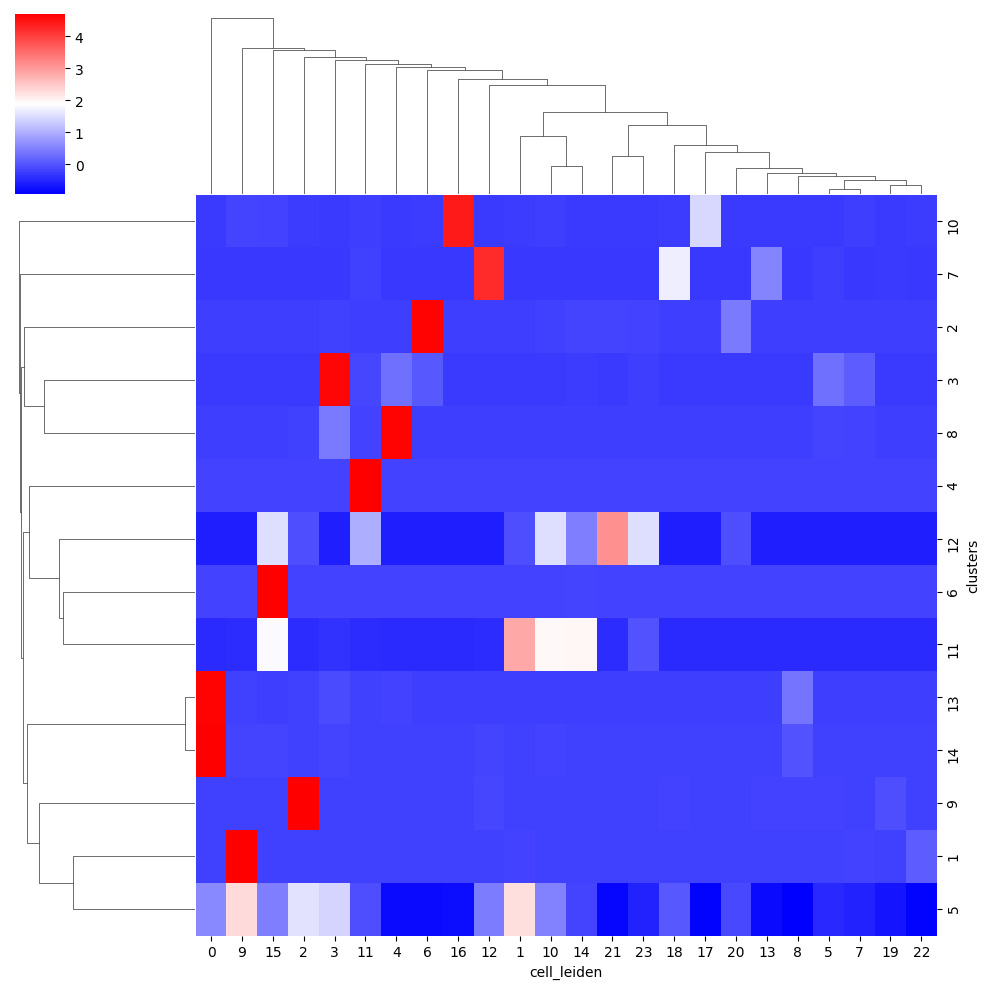

In [12]:
sns.clustermap(
    pd.crosstab(adata.obs["clusters"], adata.obs["cell_leiden"]),
    z_score=0,
    cmap="bwr"
)

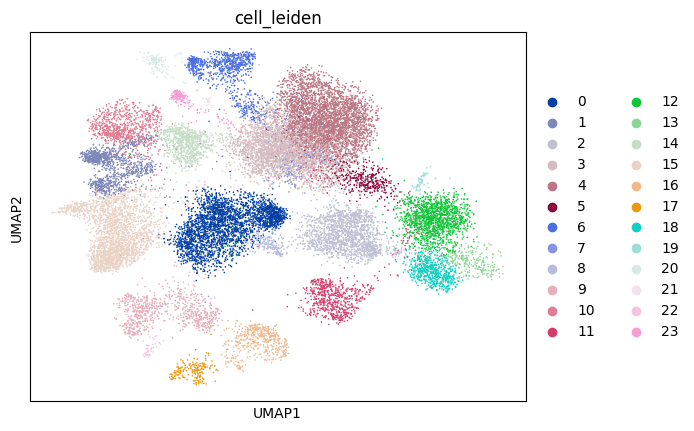

In [13]:
sc.pl.umap(adata, color=["cell_leiden"], cmap="tab20")

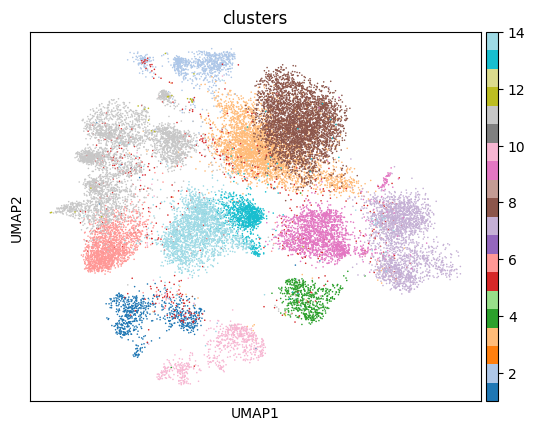

In [14]:
sc.pl.umap(adata, color=["clusters"], cmap="tab20")

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

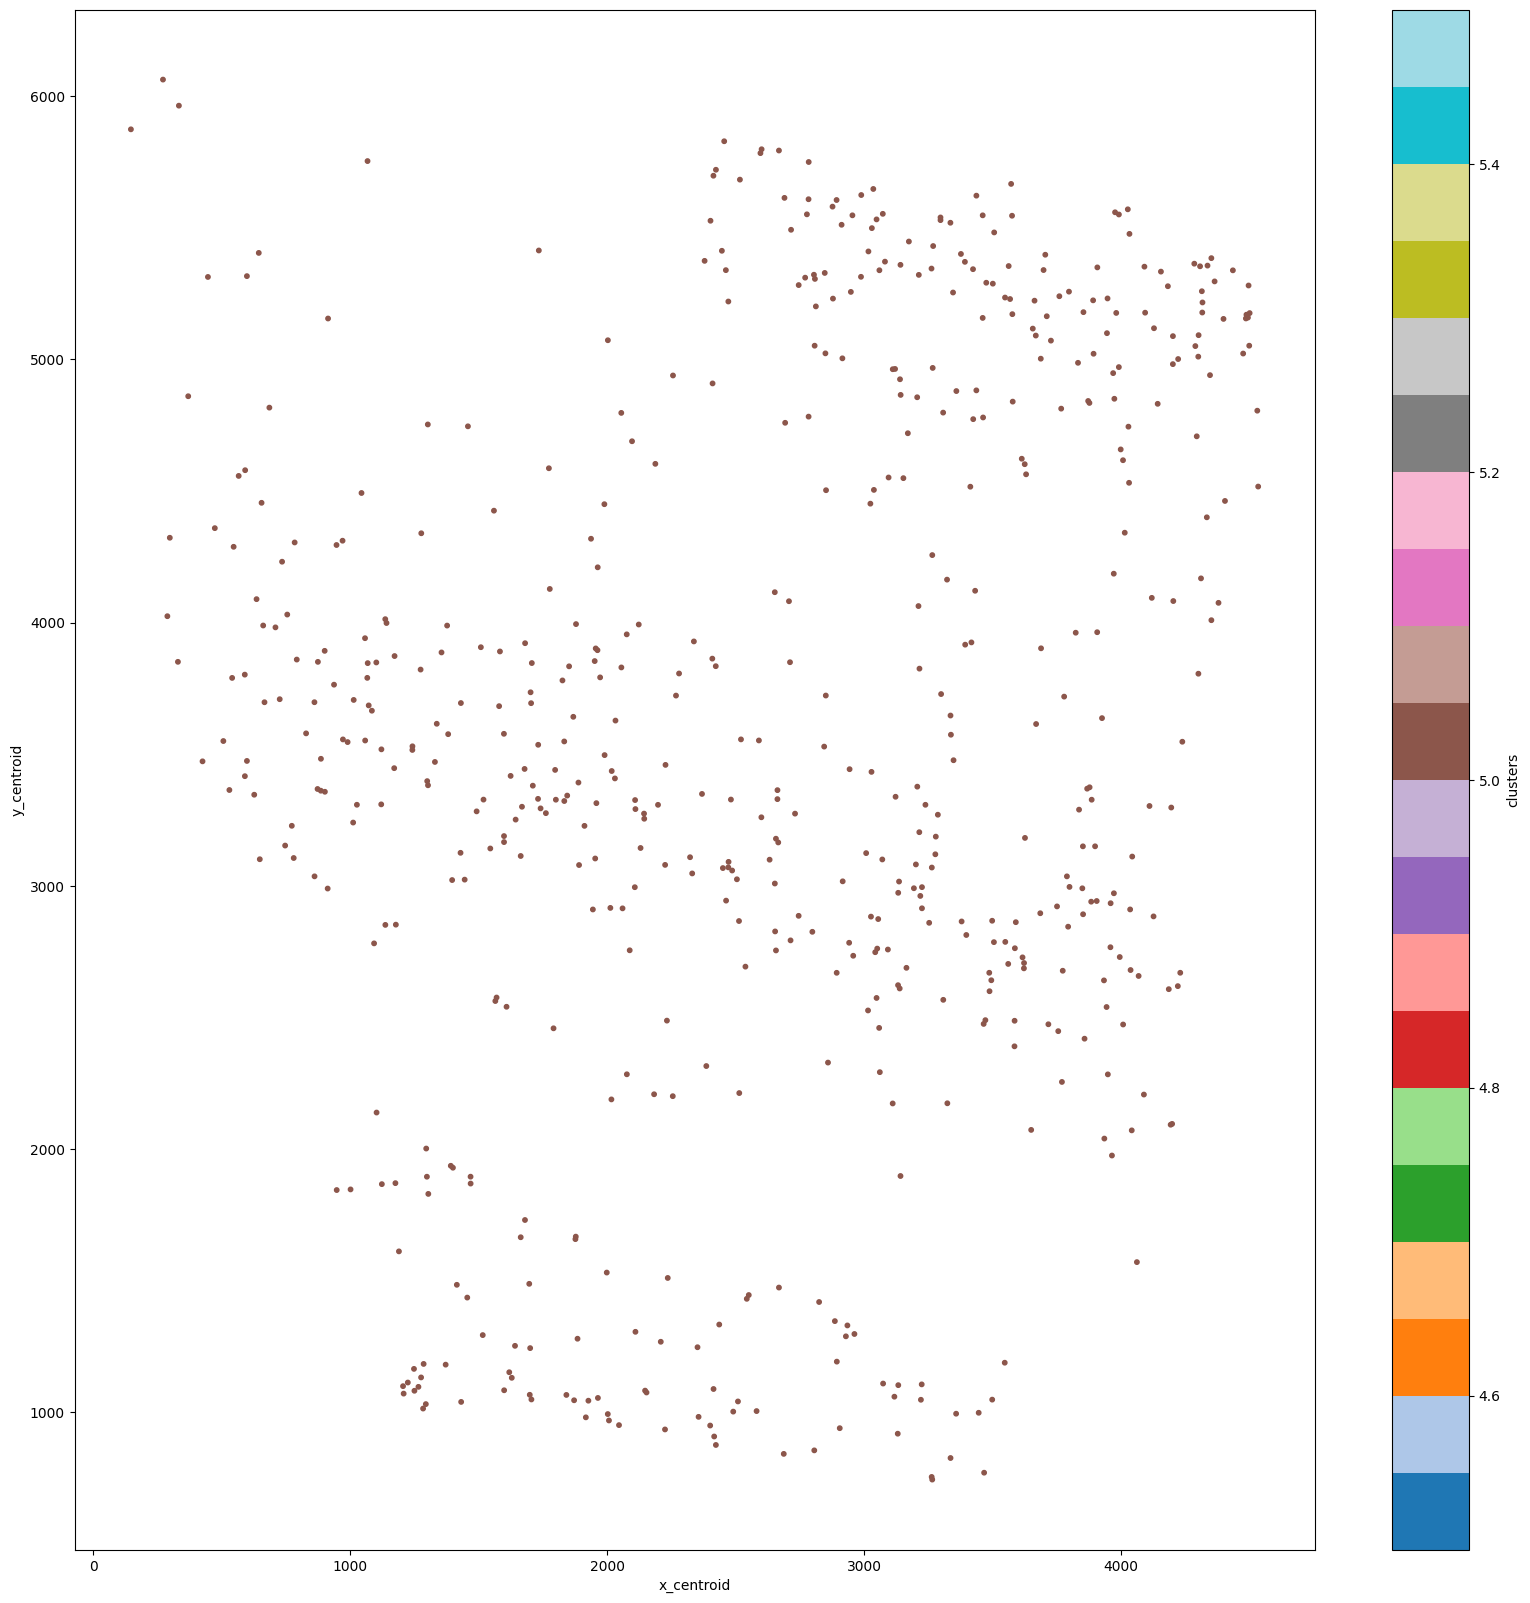

In [19]:
adata.obs.query("clusters==5").plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="clusters",
    cmap="tab20",
    s=10,
    figsize=(20, 20)
)